### notebook overview
In this notebook I'm trying to show the TPT analysis that I was doing. It relies on the segment keyword matrix that I computed in my branch of the project. This all only works on the "complete" dataset only right now.

In [59]:
import numpy as np
import pandas as pd
import os
import constants
import matplotlib.pyplot as plt
import pyemma
from tqdm.notebook import tqdm

First part is copy-paste from `train_markov_model.py`.

In [848]:

# Read the input data
input_directory = constants.output_data_segment_keyword_matrix

# Read the segment index term matrix
data = np.load(input_directory + constants.output_segment_keyword_matrix_data_file.replace('.txt', '.npy'), 
                  )

In [850]:

# Read the column index (index terms) of the matrix above
features_df = pd.read_csv(input_directory + 
                          constants.output_segment_keyword_matrix_feature_index)

# Read the row index (groups of three segments) of the matrix above
segment_df = pd.read_csv(input_directory + 
                         constants.output_segment_keyword_matrix_document_index)

# Read the input data
input_directory = constants.input_data
output_directory = constants.output_data_markov_modelling
path = os.getcwd()

# Read the biodata
bio_data = constants.input_files_biodata_birkenau
df_biodata = pd.read_csv(input_directory+bio_data)
df_biodata = df_biodata.fillna(0)

IntCodeM = df_biodata[df_biodata.Gender=='M']['IntCode'].to_list()
IntCodeW = df_biodata[df_biodata.Gender=='F']['IntCode'].to_list()



metadata_fields = ['complete','complete_m','complete_w','CountryOfBirth','CountryOfBirth_m','CountryOfBirth_w','easy_w','easy_m','medium_m','medium_w','hard_m','hard_w',"notwork","notwork_m","notwork_w","work","work_m","work_w"]



np.set_printoptions(suppress=True)



In [1197]:

# Read the input data
input_directory = constants.output_data_segment_keyword_matrix

# Read the segment index term matrix
data = np.load(input_directory + constants.output_segment_keyword_matrix_data_file.replace('.txt', '.npy'), 
                  allow_pickle=True)


# TODO: fix data loader to account for new structure
input_data_sets = {'complete':data}

#### convert trajectories using the following approach:
for each segment with multiple topics, randomly select one topic
do this for n_realization times and build the MSM on everything
the error that comes with each random pick should average out this way

this cell also assigns the last visited state if a frame is empty (row.sum() == 0)



In [1576]:

n_realizations = 50
trajs = []
for _ in tqdm(range(n_realizations)):
    for t in input_data_sets['complete']:

        _t = np.zeros_like(t)
        for n, row in enumerate(t):
            if row.sum() > 1:
                rindx = np.random.choice(row.shape[0], size=1, p=row/row.sum())
                _t[n, rindx] = 1
            elif row.sum() == 0:
                _t[n] = _t[n-1]
            else:
                _t[n] = row

        # make sure this is binary assignment
        assert np.unique(np.sum(_t, axis=1)) == np.array([1]), 'failed binary assignment'

        # convert one-hot encoding to state definitions
        trajs.append(np.argmax(_t, axis=1) )

implied timescales (its) need to be converged in MSM analysis

In [1579]:

its = pyemma.msm.timescales_msm(trajs, lags=np.arange(1, 50, 5), reversible=False)

/Users/thempel/miniconda3/envs/py37_mar20/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:549: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


20-08-20 09:51:51 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[25] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


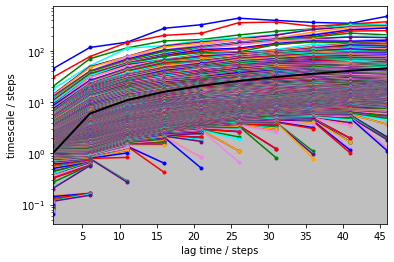

In [1837]:
pyemma.plots.plot_implied_timescales(its, marker='.', xlog=False)

#### MSM
choose MSM lag time at which it is converged;
because lag time is the time resolution of the MSM, take the minimum.
this should be in minutes because one segment is one minute long

In [1787]:
msm = pyemma.msm.estimate_markov_model(trajs, 10, reversible=False)

In [1788]:
# histogram to compare stationary distribution with (plausibility measure)
hist = np.bincount(np.concatenate(trajs))

In [1789]:
# this is the fraction of states that is connected, i.e. where 
# transitions into and out of were observed
# it's called the "active set". when working with MSMs,
# we always have to map into this set again to arrive at 
# the original state definitions

msm.active_state_fraction

0.9064327485380117

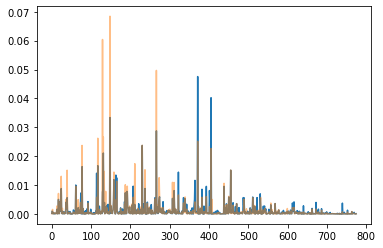

In [1790]:
plt.plot(msm.pi)
plt.plot(hist[msm.active_set]/ hist.sum(), alpha=.5)

Most likely states

In [1791]:
for i in msm.pi.argsort()[::-1][:10]:
    print(features_df.iloc[msm.active_set[i]])

Unnamed: 0                      386
KeywordID                     15474
KeywordLabel    transfer from camps
Name: 386, dtype: object
Unnamed: 0                    423
KeywordID                   15832
KeywordLabel    transfer to camps
Name: 423, dtype: object
Unnamed: 0                  156
KeywordID                 12044
KeywordLabel    camp selections
Name: 156, dtype: object
Unnamed: 0                         280
KeywordID                        15088
KeywordLabel    camp living conditions
Name: 280, dtype: object
Unnamed: 0                          243
KeywordID                         14380
KeywordLabel    camp adaptation methods
Name: 243, dtype: object
Unnamed: 0                    139
KeywordID                   10926
KeywordLabel    camp forced labor
Name: 139, dtype: object
Unnamed: 0                        125
KeywordID                       10698
KeywordLabel    mass murder awareness
Name: 125, dtype: object
Unnamed: 0             81
KeywordID            9252
KeywordLabel  

### TPT
compute transition path from "deportation to camps" to "camp liberation"; this should mark the start and end points of the story that is being told by survivers about their lives in the camp.



In [1792]:

A = features_df[features_df['KeywordLabel'].isin([
                                                  'deportation to camps'])].index.to_numpy()

B = features_df[features_df['KeywordLabel'] == 'camp liberation'].index.to_numpy()

these states have to be mapped to the active set again!

In [1795]:
msm._full2active[A], msm._full2active[B]

(array([407]), array([253]))

In [1796]:
tpt = pyemma.msm.tpt(msm, msm._full2active[A], msm._full2active[B])

### TPT plots

idea is to first show the MSM in a network presentation (which is incomprehensible because of the huge state space).
second, show the transition paths that I defined above (tpt).
last, show the most important pathways accounting for most of the flux.

In [1799]:
import networkx as nx

In [1800]:
#thres = 0.000001
fl = tpt.major_flux()
g = nx.from_numpy_array(fl, create_using=nx.DiGraph)

_m = np.zeros_like(msm.transition_matrix)
tmat_thresh = 2e-2
_m[msm.transition_matrix > tmat_thresh] = msm.transition_matrix[msm.transition_matrix > tmat_thresh]

g_tmat = nx.from_numpy_array(_m, create_using=nx.DiGraph)

In [1801]:
nodename_dict = {i:features_df.iloc[j].KeywordLabel for i, j in enumerate(msm.active_set)}
g = nx.relabel_nodes(g, nodename_dict)
g_tmat = nx.relabel_nodes(g_tmat, nodename_dict)

In [1802]:
g_tmat.number_of_edges()

6896

In [1803]:
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", 
                                                                    [(0, 0, 0, .1), (0, 0, 0, 1)])

In [1760]:
# paths = tpt.pathways(fraction=.1)
# most_important_nodes = np.unique(np.concatenate(paths[0]))

In [1761]:
# paths = tpt.pathways(fraction=.66)
# important_nodes = np.unique(np.concatenate(paths[0]))

In [1804]:
node_list = [list(g.nodes())[i] for i in important_nodes]

In [1805]:
labelthres = .01
labels = {}

for ind, (node, prob) in enumerate(zip(g.nodes, msm.pi)):
    if prob > labelthres:# or ind in most_important_nodes:
        labels[node] = node.replace(' ', '\n')
        
    elif node in features_df.iloc[A].KeywordLabel.to_list() + \
        features_df.iloc[B].KeywordLabel.to_list():
        labels[node] = node.replace(' ', '\n').upper()
        
    else:
        labels[node] = ''

print(f'{sum([l != "" for l in labels.values()])} labels to show')

17 labels to show


### MSM graph
this is the MSM graph: node sizes correspond to stationary probabilities, arrow color to transition probability

In [1768]:
weights = np.array(list(nx.get_edge_attributes(g_tmat, 'weight').values()))
#thr = .00001
#weights[weights < thr] = 0

pos = nx.fruchterman_reingold_layout(g_tmat, k=1e-1)# fixed=keep)

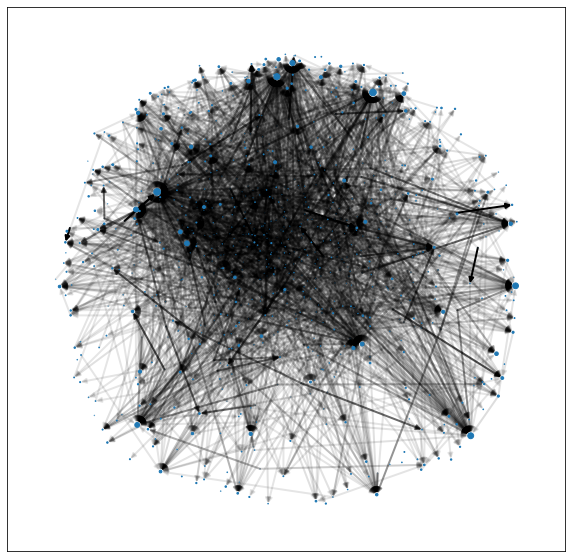

In [1769]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(g_tmat, pos, node_size=msm.pi*1000, ax=ax, )
#nx.draw_networkx_labels(g_tmat, pos, labels=labels, font_size=9)
nx.draw_networkx_edges(g_tmat, pos, edge_cmap=edge_cmap, node_size=msm.pi*1000,
                    edge_color=weights, width=2, ax=ax);

### TPT major flux
this is the major flux of the TPT, accounting for 90% of the net flux

In [1806]:
_c = msmtools.analysis.committor(msm.transition_matrix, msm._full2active[A], msm._full2active[B])

init_pos = np.random.rand(g.number_of_nodes(), 2)
init_pos[:, 0] = _c
#init_pos[_B, 0] = 1

init_pos_dict = {node:pos for pos, node in zip(init_pos, g.nodes)}



In [1807]:
weights = np.array(list(nx.get_edge_attributes(g, 'weight').values()))
#thr = .00001
#weights[weights < thr] = 0

pos = nx.fruchterman_reingold_layout(g, iterations=10, k=5e-3, pos=init_pos_dict)#) fixed=keep)

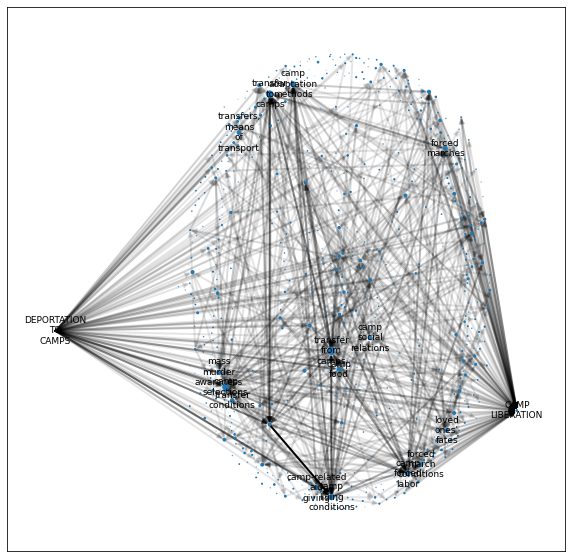

In [1808]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(g, pos, node_size=msm.pi*1000, ax=ax, )
nx.draw_networkx_labels(g, pos, labels=labels, font_size=9)
nx.draw_networkx_edges(g, pos, edge_cmap=edge_cmap, node_size=msm.pi*1000,
                    edge_color=weights, width=2, ax=ax);

# most important paths
next, only the top N paths are shown, accounting for 25% of the flux

In [1823]:
paths, capacities = tpt.pathways(fraction=.25)

In [1824]:
len(paths)

8

In [1825]:
pathgraph = nx.DiGraph()
pathg_node_names = []
pathg_nodes = []
for path, cap in zip(paths, capacities):
    for step in range(len(path)-1):
        w = cap
        _w = pathgraph.get_edge_data(path[step], path[step+1])
        if _w is not None:
            w += _w['weight']
        pathgraph.add_edge(nodename_dict[path[step]], 
                           nodename_dict[path[step+1]], weight=w)
        if nodename_dict[path[step]] not in pathg_node_names:
            pathg_node_names.append(nodename_dict[path[step]])
            pathg_nodes.append(path[step])
        if nodename_dict[path[step+1]] not in pathg_node_names:
            pathg_node_names.append(nodename_dict[path[step+1]])
            pathg_nodes.append(path[step+1])


In [1826]:
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", 
                                                                    [(0, 0, 0, .1), (0, 0, 0, 1)])

In [1827]:
labelthres = .000
labels = {}

for idx, node in zip(pathg_nodes, pathg_node_names):

    if node not in pathgraph.nodes():
        continue
    
        
    if node in features_df.iloc[A].KeywordLabel.to_list() + \
        features_df.iloc[B].KeywordLabel.to_list():
        labels[node] = node.replace(' ', '\n').upper()
    elif msm.pi[msm._full2active[idx]] > labelthres:
        labels[node] = node.replace(' ', '\n')
        
    else:
        labels[node] = ''

print(f'{sum([l != "" for l in labels.values()])} labels to show')

22 labels to show


In [1834]:
import msmtools
# this is the unsorted committor function. the other one is inplace sorted (pyemma bug??)
_c = msmtools.analysis.committor(msm.transition_matrix, msm._full2active[A], msm._full2active[B])

In [1838]:
init_pos = np.random.rand(pathgraph.number_of_nodes(), 2)
init_pos[:, 0] = _c[pathg_nodes]
#init_pos[_B, 0] = 1

init_pos_dict = {node:[_c[idx], np.random.rand()] for node, idx in zip(pathg_node_names, pathg_nodes)}


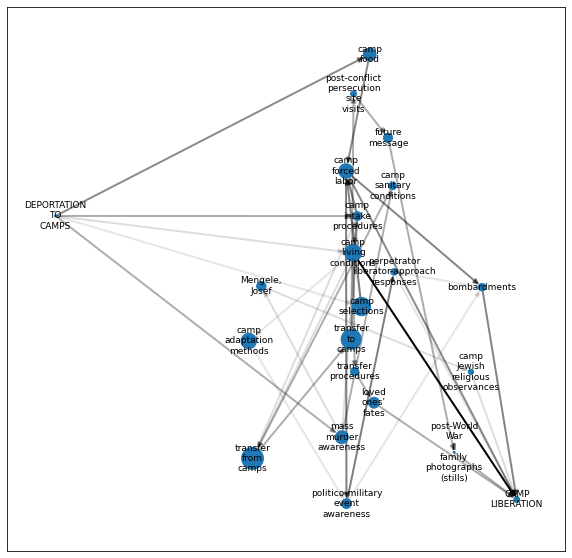

In [1840]:
weights = np.array(list(nx.get_edge_attributes(pathgraph, 'weight').values())).astype(float)
#thr = .00001
#weights[weights < thr] = 0

pos = init_pos_dict
pos = nx.fruchterman_reingold_layout(pathgraph,iterations=20, k=1.8e-2, pos=init_pos_dict, )#fixed=keep)


fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx_nodes(pathgraph, pos, node_size=msm.pi[pathg_nodes]*10000, ax=ax, )
nx.draw_networkx_labels(pathgraph, pos, labels=labels, font_size=9)
nx.draw_networkx_edges(pathgraph, pos, node_size=msm.pi[pathg_nodes]*10000,
                       edge_cmap=edge_cmap, 
                    edge_color=weights, width=2, ax=ax);